In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.modules["deepspeed"] = None
import torch
import math
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import json
import glob
from tqdm import tqdm

from afmfold.cnn import CNSteerableCNN
from afmfold.domain import compute_domain_distance, get_domain_pairs
from afmfold.utils import compute_rmsd_single_frame
from afmfold.images import generate_images
from afmfold.inference import inference
from afmfold.visualization import plot_afm
from afmfold.visualization import (
    plot_afm, apply_inverse_rotation, distribute_rots_in_grids, 
    get_default_axes, plot_pdb_z_projection, estimate_reasonable_range, 
    plot_mollweide_heatmap, plot_mollweide_scatter, plot_hist,
    )
from afmfold.rigid_body_fitting import RigidBodyFitting, run_rigid_body_fitting


/home/kawai/.conda/envs/afmfold/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Try to find the ccd cache data in the code directory for inference.


# Reproducibility Notebook

This notebook demonstrates the reproduction of the main results from the paper:

- (A) Conditional structure generation (Fig. 1)  
- (B) Evaluation of estimation error using MD data (Fig. 3)  
- (C) Comparison with rigid-body fitting (Fig. 4)  

For the reproduction of **Fig. 2**, please refer to the `README.md`.

## (A) Conditional Structure Generation (Fig. 1)

We reproduce the conditional structure generation from pseudo-AFM images.

First, we generate pseudo-AFM images from example PDB structures (open/close).

In [25]:
# Peudo-AFM image generation settings
image_dict = {
    "distance": None,
    "resolution_nm": 0.3,
    "width": 35,
    "height": 35,
    "epochs": 1,
    "dataset_size": 1,
    "min_tip_radius": 1.0,
    "max_tip_radius": 2.0,
    "noise_nm": 0.0,
}

# Load example PDB structures (open/close)
close_traj = md.load("/data/kawai/TFEP/afmfold/storage/1ake.pdb")
open_traj = md.load("/data/kawai/TFEP/afmfold/storage/4ake.pdb")

# Generate pseudo-AFM images
close_images, _ = generate_images(traj=close_traj, **image_dict)
open_images, _ = generate_images(traj=open_traj, **image_dict)


Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


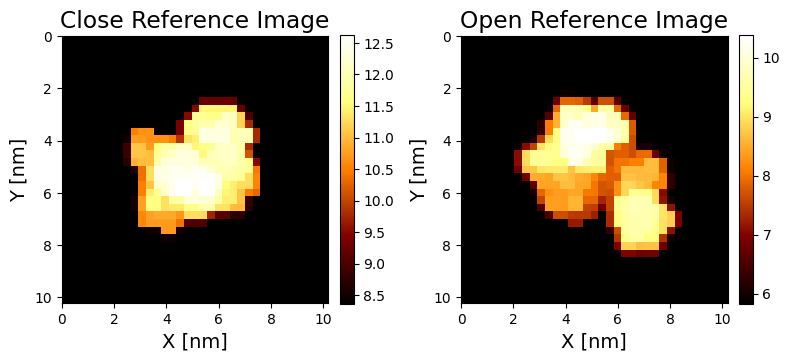

In [26]:
# Visualize the generated pseudo-AFM images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
_ = plot_afm(close_images, resolution_nm=0.3, subplots=(fig, axes[0]), title="Close Reference Image")
_ = plot_afm(open_images, resolution_nm=0.3, subplots=(fig, axes[1]), title="Open Reference Image")


Next, we load the pre-trained CNN.  
The model checkpoint is stored at `/data/kawai/TFEP/afmfold/storage/ak.pt`.

In [27]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint("/data/kawai/TFEP/afmfold/storage/ak.pt")

/home/kawai/.conda/envs/afmfold/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Before starting inference, please make sure that a JSON file `../storage/4ake.json` exists, which contains the location of the MSA.  
If it does not, either  
(i) run 
```bash
afmfold tojson --input ./storage/4ake.pdb --out_dir ./storage
afmfold msa --input ./storage/4ake.json --out_dir ./storage
```
or  
(ii) execute the following cell.

In [19]:
def _tojson(input_file, out_dir="./output", altloc="first", assembly_id=None):
    from afmfold.protenix.data.json_maker import cif_to_input_json
    from afmfold.protenix.data.utils import pdb_to_cif
    import tempfile
    import uuid
    os.makedirs(out_dir, exist_ok=True)
    stem, _ = os.path.splitext(os.path.basename(input_file))
    pdb_name = stem[:20]
    output_json = os.path.join(out_dir, f"{pdb_name}-{uuid.uuid4().hex}.json")
    if input_file.endswith(".pdb"):
        with tempfile.NamedTemporaryFile(suffix=".cif") as tmp:
            tmp_cif_file = tmp.name
            pdb_to_cif(input_file, tmp_cif_file)
            cif_to_input_json(
                tmp_cif_file,
                assembly_id=assembly_id,
                altloc=altloc,
                sample_name=pdb_name,
                output_json=output_json,
            )
    elif input_file.endswith(".cif"):
        cif_to_input_json(
            input_file,
            assembly_id=assembly_id,
            altloc=altloc,
            output_json=output_json,
        )
    else:
        raise RuntimeError(f"can not read a special ligand_file: {input_file}")
    return output_json

def _msa(input, out_dir):
    from afmfold.runner.msa_search import update_infer_json, msa_search
    from Bio import SeqIO
    if input.endswith(".json"):
        msa_input_json = update_infer_json(input, out_dir, use_msa_server=True)
        return msa_input_json
    elif input.endswith(".fasta"):
        records = list(SeqIO.parse(input, "fasta"))
        protein_seqs = []
        for seq in records:
            protein_seqs.append(str(seq.seq))
        protein_seqs = sorted(protein_seqs)
        msa_res_subdirs = msa_search(protein_seqs, out_dir)
        assert len(msa_res_subdirs) == len(msa_res_subdirs), "msa search failed"
        fasta_msa_res = dict(zip(protein_seqs, msa_res_subdirs))
        return fasta_msa_res
    else:
        raise RuntimeError(f"only support `json` or `fasta` format, but got : {input}")

# If you do not have a json file, you can create one from a PDB file as follows:
med_json = _tojson("../storage/4ake.pdb", out_dir="../storage", altloc="first", assembly_id=None)
output_json = _msa(med_json, "../storage")

# Check if MSA information is included in the generated JSON file
with open(output_json, "r") as f:
    input_data = json.load(f)
assert "msa" in input_data[0]["sequences"][0]["proteinChain"], f"MSA information is missing: {list(input_data[0]['sequences'][0]['proteinChain'].keys())}"
os.remove(med_json)

# Rename output_json {name}.json.
name = os.path.basename(output_json).split("-")[0]
json_path = os.path.join("../storage", f"{name}.json")
os.rename(output_json, json_path)


2025-10-01 11:53:50,731 [/data/kawai/TFEP/afmfold/src/afmfold/protenix/data/utils.py:426] INFO afmfold.protenix.data.utils: Saved cif in /tmp/tmpc26mej6e.cif
2025-10-01 11:53:54,778 [/data/kawai/TFEP/afmfold/src/afmfold/runner/msa_search.py:105] INFO afmfold.runner.msa_search: starting to update msa result for seq 0 in ../storage/4ake-ffc73d3b0166465fb3aa4185c4918e07.json
2025-10-01 11:53:54,787 [/data/kawai/TFEP/afmfold/src/afmfold/protenix/web_service/colab_request_utils.py:195] ERROR afmfold.protenix.web_service.colab_request_utils: Msa server is running.
COMPLETE: 100%|██████████| 100/100 [elapsed: 00:01 estimate remaining: 00:00]
2025-10-01 11:53:56,636 [/data/kawai/TFEP/afmfold/src/afmfold/runner/msa_search.py:123] INFO afmfold.runner.msa_search: update msa result success and save to /data/kawai/TFEP/afmfold/storage/4ake-ffc73d3b0166465fb3aa4185c4918e07-add-msa.json


Files downloaded and extracted successfully.


Then, we use the prediction of this CNN as restraints for the AF3's generation process.  
The generation is iteratively performed until the MSE falls below the specified `mse_threshold`.  


In [ ]:
close_cifs = inference(
    close_images, 
    model, 
    base_seed=0, 
    device="cuda", 
    json_file="../storage/4ake.json", 
    out_dir="../out/inference", 
    mse_threshold=10.0,  # in Å^2
    max_trial=5, 
    traj=close_traj,
    )

open_cifs = inference(
    open_images, 
    model, 
    base_seed=0, 
    device="cuda", 
    json_file="../storage/4ake.json", 
    out_dir="../out/inference", 
    mse_threshold=10.0,  # in Å^2
    max_trial=5, 
    traj=open_traj,
    )

100%|██████████| 1/1 [00:50<00:00, 50.28s/it]


Since the rigid-body fitting code supports batch processing, we combine the two results here.

In [30]:
# Concatenate the predicted structures
close_pred_traj = md.load(close_cifs[0])
open_pred_traj = md.load(open_cifs[0])
cat_pred_traj = md.join([close_pred_traj, open_pred_traj])
cat_ref_images = np.concatenate([close_images, open_images], axis=0)

In [31]:
# Run rigid body fitting

fitting = RigidBodyFitting(
    cat_ref_images, cat_pred_traj, 5000, 
    resolution_nm=0.3, prove_radius=1.5, min_z=0.0, ref_pdb="../storage/4ake.pdb", 
    rot_batch=1, translation_range=(-5.0, 5.0), device="cuda"
    )
summary = fitting.sample()


100%|██████████| 5000/5000 [02:06<00:00, 39.40it/s]


Then, let's visualize the results.

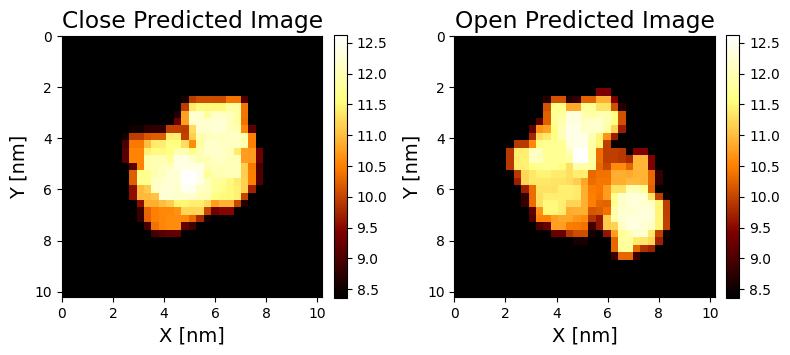

In [32]:
max_cc_id = np.argmax(summary["cc"], axis=1)
max_cc_images = summary["images"][np.arange(len(max_cc_id)), max_cc_id]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
_ = plot_afm(max_cc_images, resolution_nm=0.3, subplots=(fig, axes), title=["Close Predicted Image", "Open Predicted Image"])

## (B) Evaluation with MD Data (Fig. 3)

We evaluate the statistic prediction accuracy using MD trajectories.  

First, we load MD trajectory data. This trajectory has 64 representive frames from 450 ns MD trajectory.

In [7]:
# Load reference trajectory
ref_traj = md.load("../storage/ak.dcd", top="../storage/ak.pdb")

# Compute inter-domain distances.
domain_pairs = get_domain_pairs("4ake")
ref_domain_distance = np.zeros((ref_traj.n_frames, len(domain_pairs)))

for i, (dom1, dom2) in enumerate(domain_pairs):
    ref_domain_distance[:, i] = compute_domain_distance(ref_traj, dom1, dom2).ravel()


Next, let's convert MD frames into pseudo-AFM images.  

In [8]:
image_dict = {
    "traj": ref_traj,
    "distance": ref_domain_distance,
    "resolution_nm": 0.3,
    "width": 35,
    "height": 35,
    "epochs": 2,
    "dataset_size": 100,
    "min_tip_radius": 1.0,
    "max_tip_radius": 2.0,
    "noise_nm": 0.0,
}

# Generate pseudo-AFM images for the reference trajectory
images, labels = generate_images(**image_dict)

# Find the corresponding frames in the reference trajectory
indices = np.array([np.argmax(np.all(image_dict["distance"] == labels[i][None,:], axis=1)) for i in range(len(labels))])
frames = image_dict["traj"].atom_slice(image_dict["traj"].topology.select("element != H"))[indices]


Epoch 2/2: 100%|██████████| 2/2 [00:00<00:00, 27.44it/s]


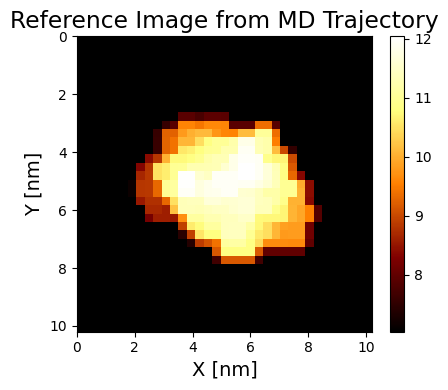

In [ ]:
# Visualize one of the generated images
fig, ax = plt.subplots(figsize=(5.0, 4.0))
_ = plot_afm(images[0], resolution_nm=0.3, subplots=(fig, ax), title="Reference Image from MD Trajectory")
plt.tight_layout()
plt.show()

Then, we load CNN parameters and start the AF3's generation conditioned on these images.  

In [10]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint("/data/kawai/TFEP/afmfold/storage/ak.pt")

/home/kawai/.conda/envs/afmfold/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [11]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
json_file = "../storage/4ake.json"  # if you do not have a json file, create one from a PDB file as shown above.
out_dir = "../out/inference"

cif_list = inference(images, model, json_file, out_dir, base_seed=0, device="cuda", max_trial=5, labels=labels, traj=frames)

100%|██████████| 200/200 [00:20<00:00,  9.86it/s]


Finally, we evaluate the estimation error statistics.

In [ ]:
def load_results(output_dirs, stop_at=None):
    # 結果の収集
    image_list = []
    true_xyz_list = []
    pred_xyz_list = []
    truth_list = []
    target_list = []
    restraint_list = []
    prediction_list = []
    for i in tqdm(range(len(output_dirs))):
        output_dir = output_dirs[i]
        cifs = glob.glob(os.path.join(output_dir, "predictions", "*.cif"))
        jsons = glob.glob(os.path.join(output_dir, "predictions", "*.json"))
        npzs = glob.glob(os.path.join(output_dir, "predictions", "*.npz"))
        assert all(len(flist) == 1 for flist in [cifs, jsons, npzs]), output_dir
        
        inputs = np.load(npzs[0])
        inputs = dict(inputs)
        
        image_list.append(inputs["image"][None,:,:])
        if "coords" in inputs:
            true_xyz_list.append(inputs["coords"][None,:,:])
        
        traj = md.load(cifs[0])
        pred_xyz_list.append(traj.xyz)
        
        with open(jsons[0], mode="r") as f:
            settings = json.load(f)
        
        if "truth" in settings:
            truth = np.array(settings["truth"])
            truth_list.append(truth[None,:])
        
        target = np.array(settings["target"])
        target_list.append(target[None,:])
        
        restraint = np.array(settings["restraint"])
        restraint_list.append(restraint[None,:])

        prediction = np.array(settings["prediction"])
        prediction_list.append(prediction[None,:])
        
        if stop_at is not None and (i+1) >= stop_at:
            break
        
    images = np.concatenate(image_list, axis=0)
    pred_xyzs = np.concatenate(pred_xyz_list, axis=0)
    if len(true_xyz_list) > 0:
        true_xyzs = np.concatenate(true_xyz_list, axis=0)
    else:
        true_xyzs = None
    if len(truth_list) > 0:
        truths = np.concatenate(truth_list, axis=0)
    else:
        truths = None
    targets = np.concatenate(target_list, axis=0)
    restraints = np.concatenate(restraint_list, axis=0)
    predictions = np.concatenate(prediction_list, axis=0)
    
    pred_traj = md.Trajectory(pred_xyzs, topology=traj.topology)
    if true_xyzs is not None:
        true_traj = md.Trajectory(true_xyzs, topology=traj.topology)
    else:
        true_traj = None
        
    return images, pred_traj, true_traj, truths, targets, restraints, predictions

def cat_data(data_dicts):
    if not data_dicts:
        return {}

    largest = sorted(data_dicts, key=lambda d: len(d))[-1]
    keys = list(largest.keys())
    out = {}

    for k in keys:
        values = [d[k] for d in data_dicts if k in d]
        out[k] = np.concatenate(values, axis=0)
    return out

def run_rigid_body_fitting(
    output_dirs, 
    ref_pdb, 
    steps=50000, 
    stop_at=None, 
    batchsize=20,
    resolution_nm=0.3, 
    prove_radius=2.0, 
    min_z=0.0,
    rot_batch=1,
    translation_range=(-5.0, 5.0),
    ):
    total_summary = {}
    images, pred_traj, true_traj, truths, targets, restraints, predictions = load_results(output_dirs, stop_at=stop_at)
    for i in range(math.ceil(len(images)/batchsize)):
        _ref_images = images[i*batchsize:(i+1)*batchsize]
        _pred_traj = pred_traj[i*batchsize:(i+1)*batchsize]
        if true_traj is not None:
            _true_traj = true_traj[i*batchsize:(i+1)*batchsize]
        if truths is not None:
            _truths = 0.1 * truths[i*batchsize:(i+1)*batchsize]
        _targets = 0.1 * targets[i*batchsize:(i+1)*batchsize]
        #_restraints = 0.1 * restraints[i*batchsize:(i+1)*batchsize]
        _predictions = 0.1 * predictions[i*batchsize:(i+1)*batchsize]
        
        fitting = RigidBodyFitting(
            _ref_images, _pred_traj, steps, 
            resolution_nm=resolution_nm, prove_radius=prove_radius, min_z=min_z, 
            ref_pdb=ref_pdb, rot_batch=rot_batch, translation_range=translation_range, device="cuda"
            )
        summary = fitting.sample()
        
        # Extract the best CC values in all rotations
        _ccs = summary["cc"]
        _best_rot_indices = np.argmax(_ccs, axis=1)
        _best_ccs = _ccs[np.arange(len(_ccs)), _best_rot_indices]
        _best_images = summary["images"][np.arange(len(_ccs)), _best_rot_indices]
        _best_rots = summary["rots"][_best_rot_indices]
        _best_coords = summary["coords"][np.arange(len(_ccs)), _best_rot_indices]
        
        if truths is not None:
            _sqerrors = np.sum((_truths - _targets)**2, axis=1)
        
        if _true_traj is not None:
            _rmsds = np.zeros((len(_pred_traj),))
            for j in range(len(_pred_traj)):
                _rmsd = compute_rmsd_single_frame(_pred_traj[j], _true_traj[j])
                _rmsds[j] = _rmsd
        
        summary = {
            "cc": _best_ccs,
            "rots": _best_rots,
            "ref_images": _ref_images,
            "pred_images": _best_images,
            "ref_coords": _true_traj.xyz,
            "pred_coords": _best_coords,
            "ref_domain_distance": _targets,
            "pred_domain_distance": _predictions,
        }
        if truths is not None:
            summary["squared_error"] = _sqerrors
        if _true_traj is not None:
            summary["rmsd"] = _rmsds
            
        total_summary = cat_data([total_summary, summary])
    
    return total_summary


In [ ]:
output_dirs = glob.glob("/data/kawai/TFEP/afmfold/out/inference/4ake/seed_*")
summary = run_rigid_body_fitting(output_dirs, ref_pdb="../storage/4ake.pdb", steps=20, stop_at=None, batchsize=20)

100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


In [ ]:
# NOTE: If you want to see the results of the paper, please load the following results.
summary = np.load("../storage/ak_summary.npz")
summary = dict(summary)

In [77]:
import py3Dmol, pathlib

def view_structures(*paths, width=600, height=450):
    path_strs = {p: pathlib.Path(p).read_text() for p in paths}
    view = py3Dmol.view(width=width, height=height)
    for path, content in path_strs.items():
        ext = os.path.splitext(path)[-1].split(".")[-1].lower()
        assert ext in ["pdb", "cif"], ext
        view.addModel(content, ext)
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.zoomTo()
    view.show()
    return view

#_ = view_structures("/data/kawai/TFEP/afmfold/notebooks/tmp/pred.pdb", "/data/kawai/TFEP/afmfold/notebooks/tmp/true.pdb")


In [ ]:
def plot_inference_results(
    summary,
    subplots=None,
    axsize=4.0,
    fontsize=14.0,
    bins=30,
    fig_padding=2.0,
    hist_padding=0.10,
    scatter_padding=0.05,
    scale_bins=5,
    compute_root=True,
):
    # --- helpers (no for-loops) ---
    def _metric_label(key: str) -> str:
        # ignore "valid" / "valid_pred", keep last token and uppercase
        label = key.split("_")[-1].upper()
        if label == "ERROR":
            if compute_root:
                label = "Root Squared Error of Inter-domain Distance [nm]"
            else:
                label = "Inter-domain Squared Error [nm$^2$]"
        elif label == "RMSD":
            label = "RMSD [nm]"
        elif label == "CC":
            label = "CC"
        return label

    def _nice_ticks(lo, hi, bins_n, name=None):
        center = (lo + hi) / 2
        width = (1 + hist_padding) * (hi - lo)
        lo_p, hi_p = center - width / 2, center + width / 2
        step = width / bins_n
        if step <= 0.01:
            decimal = 3
        elif step <= 0.1:
            decimal = 2
        else:
            decimal = 1
            
        # round outward to include the padded range
        scale = 10 ** decimal
        lo_r = np.floor(lo_p * scale) / scale
        hi_r = np.ceil(hi_p * scale) / scale
        
        step_r = np.round(step, decimal)
        # ensure positive nonzero step
        step_r = step_r if step_r > 0 else (0.1 if decimal == 1 else 0.01)
        
        name = name.split("_")[-1].upper()
        if name == "CC":
            hi_r = min(hi_r + step_r, 1.0)
            hi_r += step_r
        elif name == "ERROR":
            lo_r = max(lo_r, 0.0)
            lo_r -= step_r
        elif name == "RMSD":
            lo_r = max(lo_r, 0.0)
            hi_r += step_r
            
        ticks = np.arange(lo_r, hi_r, step_r)
        ticks = np.round(ticks, decimal)
        
        return ticks, (lo_r, hi_r)

    def _hist(ax, data, color, name=None):
        lo, hi = np.nanmin(data), np.nanmax(data)
        ticks, (lo_r, hi_r) = _nice_ticks(lo, hi, scale_bins, name=name)
        ax.hist(data, bins=bins, range=(lo_r, hi_r), density=True, color=color, edgecolor="white")
        mu = float(np.nanmean(data))
        ax.axvline(mu, linestyle="--", color="k", linewidth=1.2)
        ax.set_xlim(lo_r, hi_r)
        ax.set_xticks(ticks)
        ax.set_yticks(ax.get_yticks())  # keep default nice y ticks
        ax.tick_params(labelsize=fontsize * 0.85)

    def _scatter(ax, x, y, dot_color, names=[None,None], xmin=None, xmax=None, ymin=None, ymax=None):
        xlo = np.nanmin(x)
        xhi = np.nanmax(x)
        ylo = np.nanmin(y)
        yhi = np.nanmax(y)
        xticks, (xlo_r, xhi_r) = _nice_ticks(xlo, xhi, scale_bins, name=names[0])
        yticks, (ylo_r, yhi_r) = _nice_ticks(ylo, yhi, scale_bins, name=names[1])
        ax.scatter(x, y, s=16, alpha=0.75, color=dot_color, edgecolors="none")
        # linear regression line (thin light gray)
        coeffs = np.polyfit(np.asarray(x), np.asarray(y), 1)
        xs = np.array([xlo_r, xhi_r])
        ys = coeffs[0] * xs + coeffs[1]
        ax.plot(xs, ys, linewidth=1.5, color="#cfcfcf", ls="--")
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xlim(np.min(xticks), np.max(xticks))
        ax.set_ylim(np.min(yticks), np.max(yticks))
        ax.tick_params(labelsize=fontsize * 0.85)

    #print("MSE: ", np.mean(summary['squared_error']))
    print(f"RMSE: {np.mean(np.sqrt(summary['squared_error']))}")
    print(f"RRMSD: {np.mean(summary['rmsd'])}")
    print(f"MCC: {np.mean(summary['cc'])}")
    
    # --- layout ---
    if subplots is None:
        fig, axes = plt.subplots(2, 3, figsize=(3 * axsize + fig_padding, 2 * axsize), constrained_layout=True)
    else:
        fig, axes = subplots
    
    # --- histograms (colors fixed as requested) ---
    if compute_root:
        _hist(axes[0, 0], np.sqrt(summary["squared_error"]), color="salmon", name="squared_error")
    else:
        _hist(axes[0, 0], summary["squared_error"], color="salmon", name="squared_error")
    _hist(axes[0, 1], summary["rmsd"], color="skyblue", name="rmsd")
    _hist(axes[0, 2], summary["cc"], color="moccasin", name="cc")

    # --- scatter plots (choose pleasant, distinct colors not overlapping with histogram palette) ---
    if compute_root:
        _scatter(axes[1, 0], np.sqrt(summary["squared_error"]), summary["rmsd"], dot_color="mediumseagreen", names=["squared_error", "rmsd"])
    else:
        _scatter(axes[1, 0], summary["squared_error"], summary["rmsd"], dot_color="mediumseagreen", names=["squared_error", "rmsd"])
    _scatter(axes[1, 1], summary["squared_error"], summary["cc"], dot_color="orchid", names=["squared_error", "cc"])
    _scatter(axes[1, 2], summary["cc"], summary["rmsd"], dot_color="steelblue", names=["cc", "rmsd"])
    
    # --- labels (no titles) ---
    # row 1: histograms (x-labels only)
    axes[0, 0].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    axes[0, 1].set_xlabel(_metric_label("rmsd"), fontsize=fontsize)
    axes[0, 2].set_xlabel(_metric_label("cc"), fontsize=fontsize)
    # row 2: scatters (x and y)
    axes[1, 0].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    axes[1, 0].set_ylabel(_metric_label("rmsd"), fontsize=fontsize)
    axes[1, 1].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    axes[1, 1].set_ylabel(_metric_label("cc"), fontsize=fontsize)
    axes[1, 2].set_xlabel(_metric_label("cc"), fontsize=fontsize)
    axes[1, 2].set_ylabel(_metric_label("rmsd"), fontsize=fontsize)

    return fig, axes


RMSE: 0.25481928496814743
RRMSD: 0.28060460090637207
MCC: 0.9979248046875


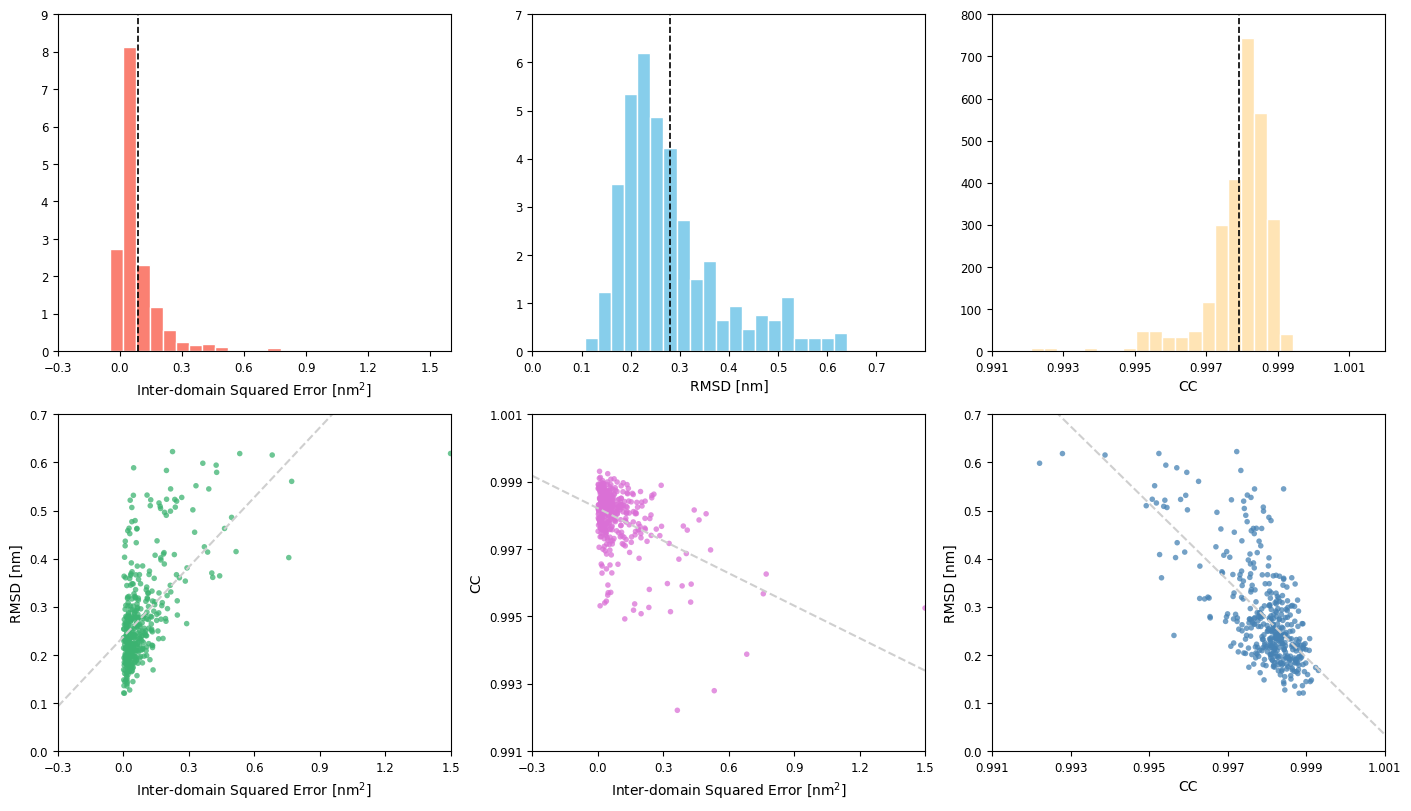

In [119]:
fig, axes = plot_inference_results(summary, fontsize=10, compute_root=False)

## (C) Comparison with Rigid-Body Fitting (Fig. 4)

We compare our method against rigid-body fitting as a baseline.  

First, we generate images from MD trajectories. Here, we assume them as the real AFM data.

In [125]:
ref_traj = md.load("../storage/flhac.dcd", top="../storage/flhac.pdb")
ref_traj

<mdtraj.Trajectory with 200 frames, 5424 atoms, 346 residues, and unitcells at 0x7f386baf46d0>

In generating pseudo-AFM images, we use `skimage.exposure.match_histograms` to match histograms so that generated images are close to real AFM images.
Note that, in the paper, we actually performed histogram matching during the generation of training data.  


In [147]:
real_image_histogram = np.load("../storage/real_afm_histogram.npy")

In [183]:
# Peudo-AFM image generation settings
image_dict = {
    "distance": None,
    "resolution_nm": 0.98,
    "width": 35,
    "height": 35,
    "epochs": 1,
    "dataset_size": len(ref_traj),
    "min_tip_radius": 2.0,
    "max_tip_radius": 5.0,
    "noise_nm": 1.0,
    "ref_images": real_image_histogram,
    "match_histgram": True,
}

# Generate pseudo-AFM images
ref_images, _ = generate_images(traj=ref_traj, **image_dict)

Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


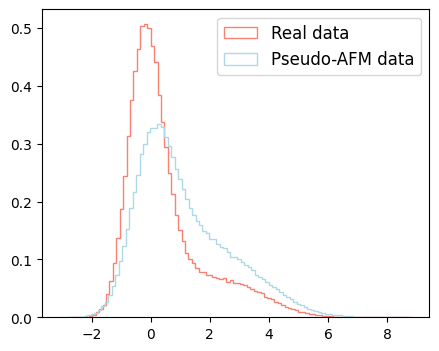

In [184]:
fig, ax = plt.subplots(figsize=(5.0, 4.0))
_ = ax.hist(real_image_histogram, bins=100, histtype='step', density=True, color="salmon", label="Real data")
_ = ax.hist(ref_images.ravel(), bins=100, histtype='step', density=True, color="lightblue", label="Pseudo-AFM data")
ax.legend(fontsize=12)
plt.show()

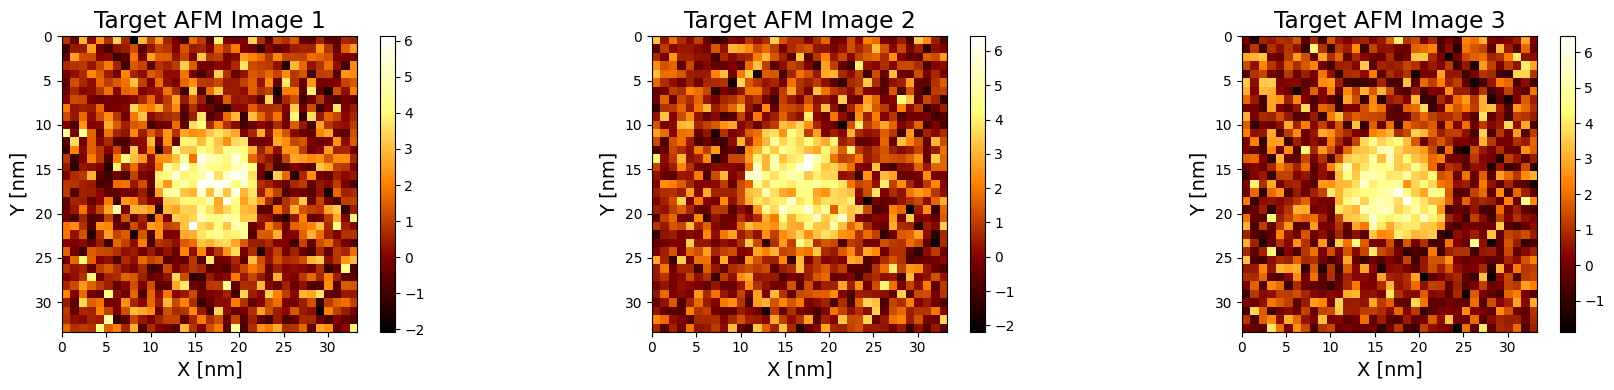

In [ ]:
target_afm_images = ref_images[[1,9,15]]
_ = plot_afm(target_afm_images, resolution_nm=0.98, title=["Target AFM Image 1", "Target AFM Image 2", "Target AFM Image 3"])

Next, we load the pre-trained CNN model.

In [193]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint("../storage/flhac.pt")

Also, get the json file with MSA path.

In [188]:
def _tojson(input_file, out_dir="./output", altloc="first", assembly_id=None):
    from afmfold.protenix.data.json_maker import cif_to_input_json
    from afmfold.protenix.data.utils import pdb_to_cif
    import tempfile
    import uuid
    os.makedirs(out_dir, exist_ok=True)
    stem, _ = os.path.splitext(os.path.basename(input_file))
    pdb_name = stem[:20]
    output_json = os.path.join(out_dir, f"{pdb_name}-{uuid.uuid4().hex}.json")
    if input_file.endswith(".pdb"):
        with tempfile.NamedTemporaryFile(suffix=".cif") as tmp:
            tmp_cif_file = tmp.name
            pdb_to_cif(input_file, tmp_cif_file)
            cif_to_input_json(
                tmp_cif_file,
                assembly_id=assembly_id,
                altloc=altloc,
                sample_name=pdb_name,
                output_json=output_json,
            )
    elif input_file.endswith(".cif"):
        cif_to_input_json(
            input_file,
            assembly_id=assembly_id,
            altloc=altloc,
            output_json=output_json,
        )
    else:
        raise RuntimeError(f"can not read a special ligand_file: {input_file}")
    return output_json

def _msa(input, out_dir):
    from afmfold.runner.msa_search import update_infer_json, msa_search
    from Bio import SeqIO
    if input.endswith(".json"):
        msa_input_json = update_infer_json(input, out_dir, use_msa_server=True)
        return msa_input_json
    elif input.endswith(".fasta"):
        records = list(SeqIO.parse(input, "fasta"))
        protein_seqs = []
        for seq in records:
            protein_seqs.append(str(seq.seq))
        protein_seqs = sorted(protein_seqs)
        msa_res_subdirs = msa_search(protein_seqs, out_dir)
        assert len(msa_res_subdirs) == len(msa_res_subdirs), "msa search failed"
        fasta_msa_res = dict(zip(protein_seqs, msa_res_subdirs))
        return fasta_msa_res
    else:
        raise RuntimeError(f"only support `json` or `fasta` format, but got : {input}")

# If you do not have a json file, you can create one from a PDB file as follows:
med_json = _tojson("../storage/3a5i.pdb", out_dir="../storage", altloc="first", assembly_id=None)
output_json = _msa(med_json, "../storage")

# Check if MSA information is included in the generated JSON file
with open(output_json, "r") as f:
    input_data = json.load(f)
assert "msa" in input_data[0]["sequences"][0]["proteinChain"], f"MSA information is missing: {list(input_data[0]['sequences'][0]['proteinChain'].keys())}"
os.remove(med_json)

# Rename output_json {name}.json.
name = os.path.basename(output_json).split("-")[0]
json_path = os.path.join("../storage", f"{name}.json")
os.rename(output_json, json_path)


2025-10-01 15:37:17,033 [/data/kawai/TFEP/afmfold/src/afmfold/protenix/data/utils.py:426] INFO afmfold.protenix.data.utils: Saved cif in /tmp/tmpvy49yrlu.cif
2025-10-01 15:37:21,287 [/data/kawai/TFEP/afmfold/src/afmfold/runner/msa_search.py:105] INFO afmfold.runner.msa_search: starting to update msa result for seq 0 in ../storage/3a5i-66f8b0f4e4eb4b00994edd6101c36609.json
2025-10-01 15:37:21,294 [/data/kawai/TFEP/afmfold/src/afmfold/protenix/web_service/colab_request_utils.py:195] ERROR afmfold.protenix.web_service.colab_request_utils: Msa server is running.
COMPLETE: 100%|██████████| 100/100 [elapsed: 00:01 estimate remaining: 00:00]

Files downloaded and extracted successfully.



2025-10-01 15:37:23,610 [/data/kawai/TFEP/afmfold/src/afmfold/runner/msa_search.py:123] INFO afmfold.runner.msa_search: update msa result success and save to /data/kawai/TFEP/afmfold/storage/3a5i-66f8b0f4e4eb4b00994edd6101c36609-add-msa.json


Finally, we start inference from the afm images.

In [196]:
json_file = "../storage/3a5i.json"
out_dir = "../out/inference"

cif_list = inference(target_afm_images, model, json_file, out_dir, base_seed=0, device="cuda", max_trial=5)

100%|██████████| 3/3 [04:05<00:00, 81.82s/it]


In [210]:
from pathlib import Path
output_dirs = [str(Path(p).resolve().parent.parent) for p in cif_list]
print(output_dirs)

['/data/kawai/TFEP/afmfold/out/inference/3a5i/seed_0', '/data/kawai/TFEP/afmfold/out/inference/3a5i/seed_1', '/data/kawai/TFEP/afmfold/out/inference/3a5i/seed_2']


To perform rigid-body fitting between the predicted structure and the crystal structure,  
set the `use_ref_structure` flag to `True` and then run the `run_rigid_body_fitting` function.

In [ ]:
total_summary = run_rigid_body_fitting(
    output_dirs, 
    ref_pdb="../storage/3a5i.pdb", 
    resolution_nm=0.98, 
    prove_radius=2.0,
    min_z=0.0,
    steps=50000,
    stop_at=None, 
    batchsize=20,
    use_ref_structure=True,
    device="cpu",
    )

Finally, let’s plot the results of the rigid-body fitting.

In [15]:
def plot_rigid_body_fitting_results(
    summary, 
    ref_pdb, 
    target=None, 
    resolution_nm=0.98, 
    lat_grid=90, 
    lon_grid=45, 
    hist_vmin=None, 
    hist_vmax=None, 
    figsize=4.0,
    ):
    # 結果を整理
    _ccs = summary["all_cc"]
    _rots = np.concatenate([summary["all_rots"][None,:,:,:] for _ in range(len(_ccs))], axis=0)
    _best_rots = summary["rots"]
    _best_images = summary["pred_images"]
    _best_coords = summary["pred_coords"]
    _ref_images = summary["ref_images"]
    assert len(_ccs) % 2 == 0
    num_frames = int(len(_ccs) / 2)
    if target is not None:
        assert 0 <= target <= num_frames - 1, target
        indices = [target]
    else:
        indices = [i for i in range(num_frames)]
    ref_traj = md.load(ref_pdb)
    
    # Distribute the rotations in the grids
    _rots = apply_inverse_rotation(_rots, _best_rots)
    _best_rots = apply_inverse_rotation(_best_rots[:,None,:,:], _best_rots)[:,0,:,:]
    assert len(_rots) == len(_best_rots) == len(_ccs)
    corr_values_list = []
    best_index_list = []
    for j in range(len(_rots)):
        _corr_values, _best_index = distribute_rots_in_grids(_rots[j], _best_rots[j], _ccs[j], lat_grid=lat_grid, lon_grid=lon_grid)
        corr_values_list.append(_corr_values[None,:])
        best_index_list.append(_best_index)
    corr_on_grids = np.concatenate(corr_values_list, axis=0)
    best_indices = np.concatenate(best_index_list, axis=0)
    
    # 予測構造を使った結果とデータベース構造を使った結果を分離
    corr_on_grids_pred = corr_on_grids[:num_frames]
    best_index_pred = best_indices[:num_frames]
    corr_so3_pred = _ccs[:num_frames]
    best_images_pred = _best_images[:num_frames]
    best_traj_pred = md.Trajectory(_best_coords[:num_frames], topology=ref_traj.topology)
    
    corr_on_grids_rigid = corr_on_grids[num_frames:]
    best_index_rigid = best_indices[num_frames:]
    corr_so3_rigid = _ccs[num_frames:]
    best_images_rigid = _best_images[num_frames:]
    best_traj_rigid = md.Trajectory(_best_coords[num_frames:], topology=ref_traj.topology)
    
    subplots_list = []
    for idx in indices:
        # 結果をプロット
        fig, axes = get_default_axes(figsize=figsize)
        subplots_list.append((fig, axes))
        
        if _ref_images is not None:
            plot_afm(_ref_images[idx], resolution_nm=resolution_nm, subplots=(fig, axes[0,0]))
            axes[0,0].set_title(None)
            axes[0,0].set_xlabel("X [nm]")
            axes[0,0].set_ylabel("Y [nm]")
    
        plot_afm(best_images_pred[idx], resolution_nm=resolution_nm, subplots=(fig, axes[0,1]))
        axes[0,1].set_title(None)
        axes[0,1].set_xlabel("X [nm]")
        axes[0,1].set_ylabel("Y [nm]")
    
        plot_pdb_z_projection(best_traj_pred[idx], subplots=(fig, axes[0,1]), set_title=False, unit="nm", r=0.5)
    
        plot_afm(best_images_rigid[idx], resolution_nm=resolution_nm, subplots=(fig, axes[1,1]))
        axes[1,1].set_title(None)
        axes[1,1].set_xlabel("X [nm]")
        axes[1,1].set_ylabel("Y [nm]")
    
        plot_pdb_z_projection(best_traj_rigid[idx], subplots=(fig, axes[1,1]), set_title=False, unit="nm", r=0.5)
    
        # データ範囲を決定
        all_corr = np.concatenate([corr_so3_pred[idx].ravel(), corr_so3_rigid[idx].ravel()], axis=0)
        vmin, vmax, _ = estimate_reasonable_range(all_corr, min_r=0.1, max_r=0.9, r=4.0)
        if hist_vmin is None or hist_vmax is None:
            hist_vmin, hist_vmax = 0.650, 0.850
    
        _ = plot_mollweide_heatmap(corr_on_grids_pred[idx], label="CC", title=None, subplots=(fig, axes[0,2]), vmin=vmin, vmax=vmax)

        _ = plot_mollweide_scatter(best_index_pred[idx][None,:], lat_grid, lon_grid, subplots=(fig, axes[0,2]), marker="*", s=100, color="yellow", linewidths=1.5, edgecolors="black")
    
        _ = plot_hist(corr_so3_pred[idx], pad=0.2, subplots=(fig, axes[0,3]), xlabel="CC", ylabel="Density", title=None, density=True, vmin=hist_vmin, vmax=hist_vmax, bins=50)
    
        _ = plot_mollweide_heatmap(corr_on_grids_rigid[idx], label="CC", title=None, subplots=(fig, axes[1,2]), vmin=vmin, vmax=vmax)

        _ = plot_mollweide_scatter(best_index_rigid[idx][None,:], lat_grid, lon_grid, subplots=(fig, axes[1,2]), marker="*", s=100, color="yellow", linewidths=1.5, edgecolors="black")
    
        _ = plot_hist(corr_so3_rigid[idx].ravel(), pad=0.2, subplots=(fig, axes[1,3]), xlabel="CC", ylabel="Density", title=None, density=True, vmin=hist_vmin, vmax=hist_vmax, bins=50)

    return tuple(subplots_list)

In [ ]:
_ = plot_rigid_body_fitting_results(total_summary, ref_pdb="../storage/3a5i.pdb", target=0)